In [1]:
!pip install -q umap-learn

In [2]:
from google.colab import drive
drive.mount('/content/drive')

Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).


In [3]:
import os
import sys
sys.path.append('drive/MyDrive/HKUST/Comp 4641 Project')

In [4]:
from node2vec import Deepwalk, node2vec
from sklearn.manifold import TSNE
import umap
from sklearn.cluster import DBSCAN, MeanShift
from cluster import Embedding
from collections import defaultdict
import networkx as nx
import numpy as np
import csv

# Build network

In [5]:
def load_data(file_name):
    """
    read edges from an edge file
    """
    edges = list()
    df = pd.read_csv(file_name)
    for user_id, friends in zip(df["user_id"], df["friends"]):
        friends = eval(friends)
        for friend in friends:
            # add each friend relation as an edge
            edges.append((user_id, friend))
    edges = sorted(edges)
    
    return edges

def construct_graph_from_edges(edges):
    """
    generate a directed graph object given true edges
    DiGraph documentation: https://networkx.github.io/documentation/stable/reference/classes/digraph.html
    """
    # convert a list of edges {(u, v)} to a list of edges with weights {(u, v, w)}
    edges = sorted(edges)
    edge_weight = defaultdict(float)
    for e in edges:
        edge_weight[e] += 1.0
    weighed_edge_list = list()
    for e in sorted(edge_weight.keys()):
        weighed_edge_list.append((e[0], e[1], edge_weight[e]))
        
    graph = nx.Graph()
    graph.add_weighted_edges_from(weighed_edge_list)
    
    print("number of nodes:", graph.number_of_nodes())
    print("number of edges:", graph.number_of_edges())
    
    return graph

number of nodes: 3425
number of edges: 98148
building a node2vec model...	number of walks: 34250	average walk length: 9.7740	trainig time: 84.3352
0.9923990245302161


0.9202662871750179

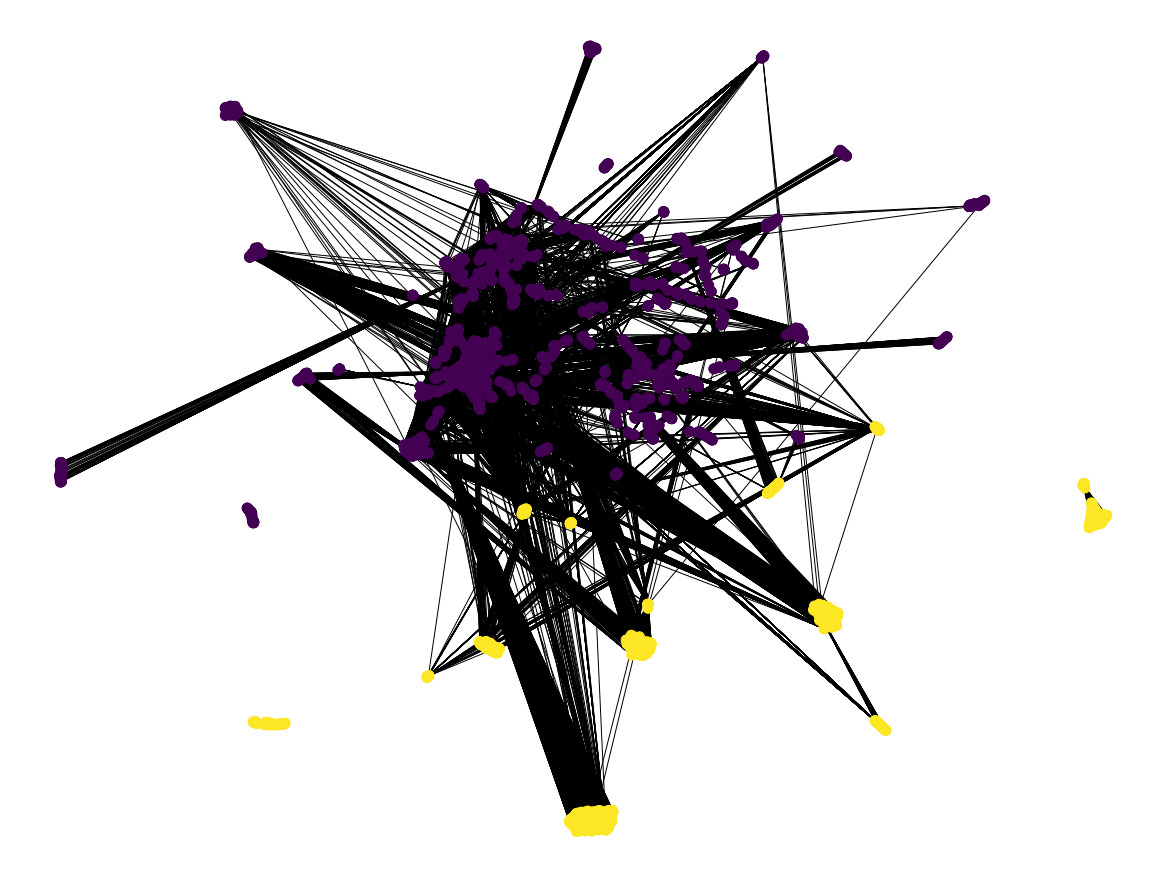

In [7]:
retweet_graph = nx.readwrite.gexf.read_gexf("drive/MyDrive/HKUST/Comp 4641 Project/networks/mask_co_hashtag_t2.gexf")
print("number of nodes:", retweet_graph.number_of_nodes())
print("number of edges:", retweet_graph.number_of_edges())
n2v = node2vec(retweet_graph, p=5)
n2v()
print(n2v.evaluate())
emb = Embedding(n2v.get_embedding())
emb.dimReduce()
emb.cluster()
emb.plot(n2v.graph)
emb.evaluate_dimReduce(n2v.valid_edges, n2v.false_edges)

In [12]:
import csv

f = open('drive/MyDrive/HKUST/Comp 4641 Project/mask_co_hashtag_t2_cluster.csv', 'w')

writer = csv.writer(f)
writer.writerow(['node', 'cluster'])
for key, value in emb.nodes_cluster.items():
    writer.writerow([key, value])

f.close()